In [245]:
## **DSA210 Term Project**

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr


In [247]:
### **Data Process**

In [248]:
file_path = "dataset_traveltime.csv" 
df = pd.read_csv(file_path, delimiter=';')
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
df['DepartureTime'] = pd.to_datetime(df['DepartureTime'], format='%H:%M').dt.time
df['TravelDuration'] = df['TravelDuration'].astype(int)
df['StressLevelBefore'] = df['StressLevelBefore'].astype(int)
df['StressLevelAfter'] = df['StressLevelAfter'].astype(int)
df['HighTemp'] = df['HighTemp'].astype(int)
df['LowTemp'] = df['LowTemp'].astype(int)
df['StressLevelDifference'] = df['StressLevelAfter'] - df['StressLevelBefore']
df['AvgTemp'] = (df['HighTemp'] + df['LowTemp']) / 2
weather_encoded = pd.get_dummies(df['WeatherCondition'], prefix='Weather')
df = pd.concat([df, weather_encoded], axis=1)

processed_file_path = "processed_travel_data.csv"
df.to_csv(processed_file_path, index=False)
print(f"Processed dataset saved to {processed_file_path}")

Processed dataset saved to processed_travel_data.csv


In [249]:
### **Univariate Analysis**

In [250]:
### Histogram

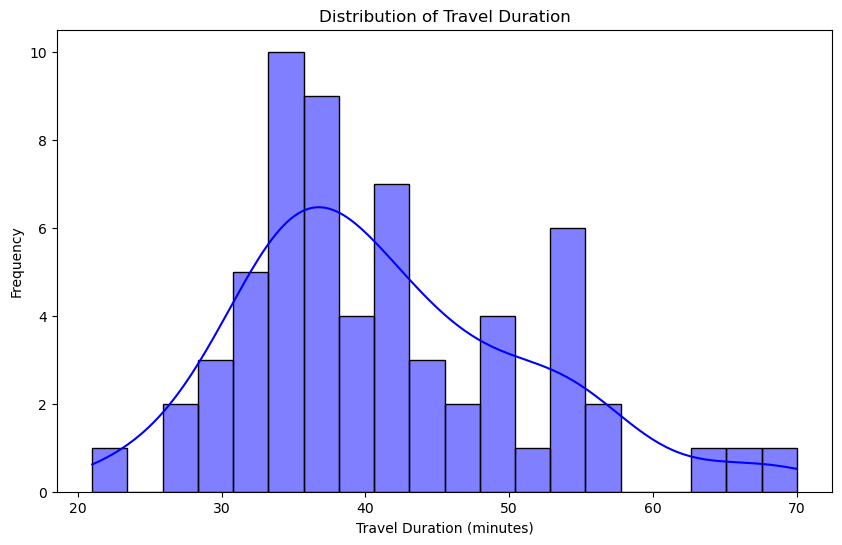

Travel Duration Statistics:
Mean: 41.55 minutes
Median: 39.50 minutes
Mode: 35 minutes


In [251]:
plt.figure(figsize=(10, 6))
sns.histplot(df['TravelDuration'], kde=True, bins=20, color='blue')
plt.title("Distribution of Travel Duration")
plt.xlabel("Travel Duration (minutes)")
plt.ylabel("Frequency")
plt.show()


mean_duration = df['TravelDuration'].mean()
median_duration = df['TravelDuration'].median()
mode_duration = df['TravelDuration'].mode()[0]

print("Travel Duration Statistics:")
print(f"Mean: {mean_duration:.2f} minutes")
print(f"Median: {median_duration:.2f} minutes")
print(f"Mode: {mode_duration} minutes")












In [252]:
### Bar Chart(Count Plot)

C:\Users\berkn\AppData\Local\Temp\ipykernel_27624\2592757664.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='WeatherCondition', data=df, palette="pastel")


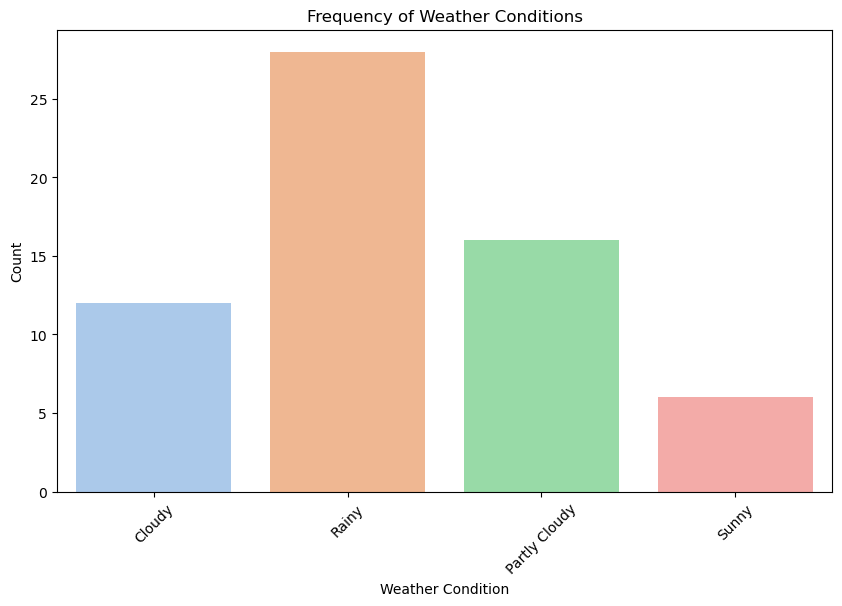

In [253]:
plt.figure(figsize=(10, 6))
sns.countplot(x='WeatherCondition', data=df, palette="pastel")
plt.title("Frequency of Weather Conditions")
plt.xlabel("Weather Condition")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

df['DepartureTimeHour'] = df['DepartureTime'].apply(lambda x: x.hour + x.minute / 60)


In [254]:
### **Bivariate Analysis**

In [255]:
### Boxplot

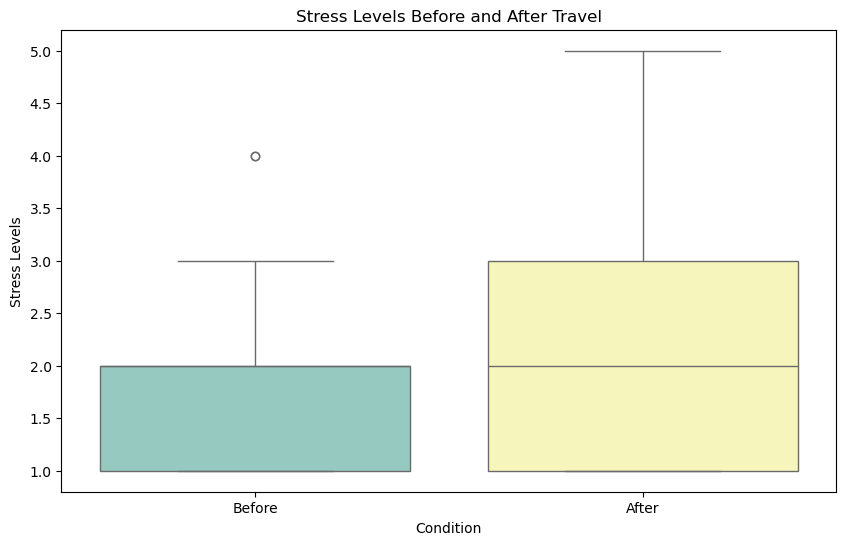

In [256]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['StressLevelBefore', 'StressLevelAfter']], palette="Set3")
plt.title("Stress Levels Before and After Travel")
plt.ylabel("Stress Levels")
plt.xlabel("Condition")
plt.xticks([0, 1], ['Before', 'After'])
plt.show()

In [257]:
### Scatterplot

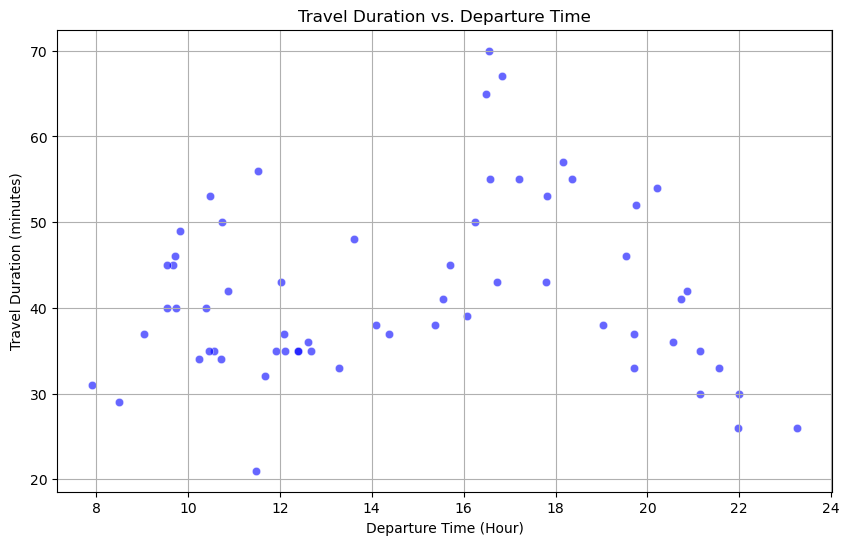

In [258]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DepartureTimeHour', y='TravelDuration', data=df, alpha=0.6, color='blue')
plt.title("Travel Duration vs. Departure Time")
plt.xlabel("Departure Time (Hour)")
plt.ylabel("Travel Duration (minutes)")
plt.grid(True)
plt.show()


In [259]:
### Boxplot

C:\Users\berkn\AppData\Local\Temp\ipykernel_27624\733319881.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WeatherCondition', y='TravelDuration', data=df, palette="Set2")


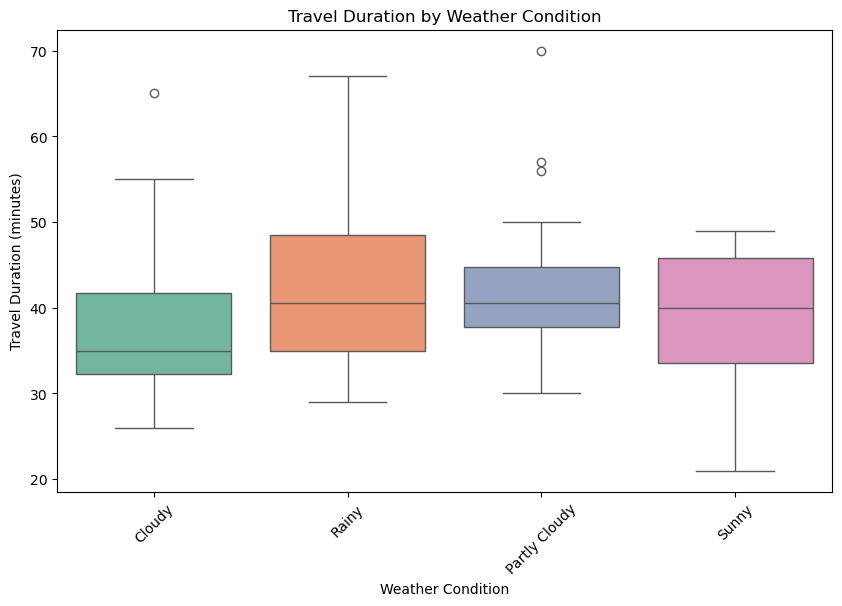

In [260]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='WeatherCondition', y='TravelDuration', data=df, palette="Set2")
plt.title("Travel Duration by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Travel Duration (minutes)")
plt.xticks(rotation=45)
plt.show()

In [261]:
### Boxplot

C:\Users\berkn\AppData\Local\Temp\ipykernel_27624\295284894.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='WeatherCondition', y='StressLevelDifference', data=df, palette="muted")


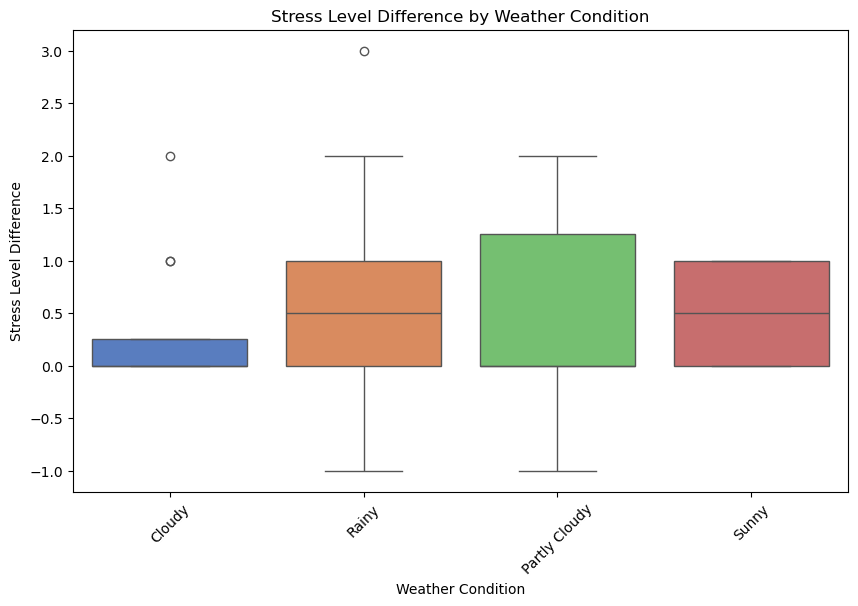

In [262]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='WeatherCondition', y='StressLevelDifference', data=df, palette="muted")
plt.title("Stress Level Difference by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Stress Level Difference")
plt.xticks(rotation=45)
plt.show()

In [263]:
### Scatterplot with a trendline

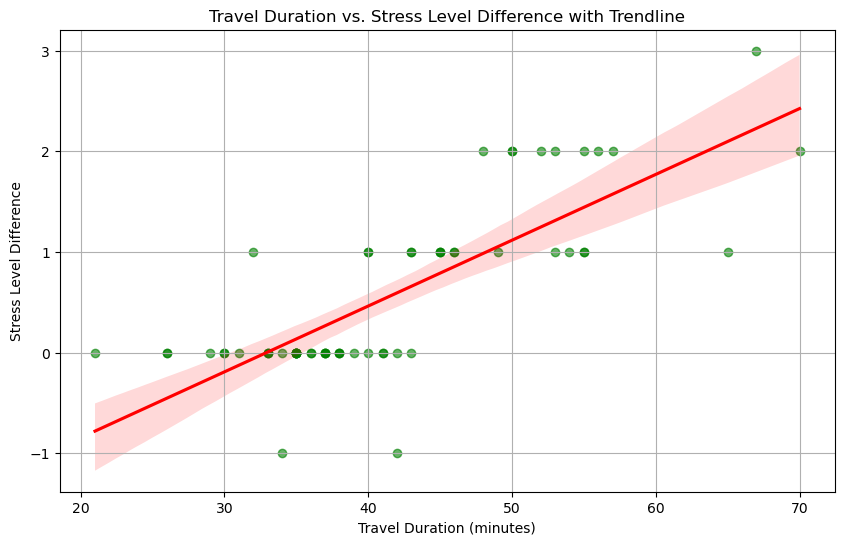

In [264]:
plt.figure(figsize=(10, 6))
sns.regplot(x='TravelDuration', y='StressLevelDifference', data=df, color='green', scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title("Travel Duration vs. Stress Level Difference with Trendline")
plt.xlabel("Travel Duration (minutes)")
plt.ylabel("Stress Level Difference")
plt.grid(True)
plt.show()

In [265]:
### **Multivariate Analysis**

In [266]:
### Scatterplot with color

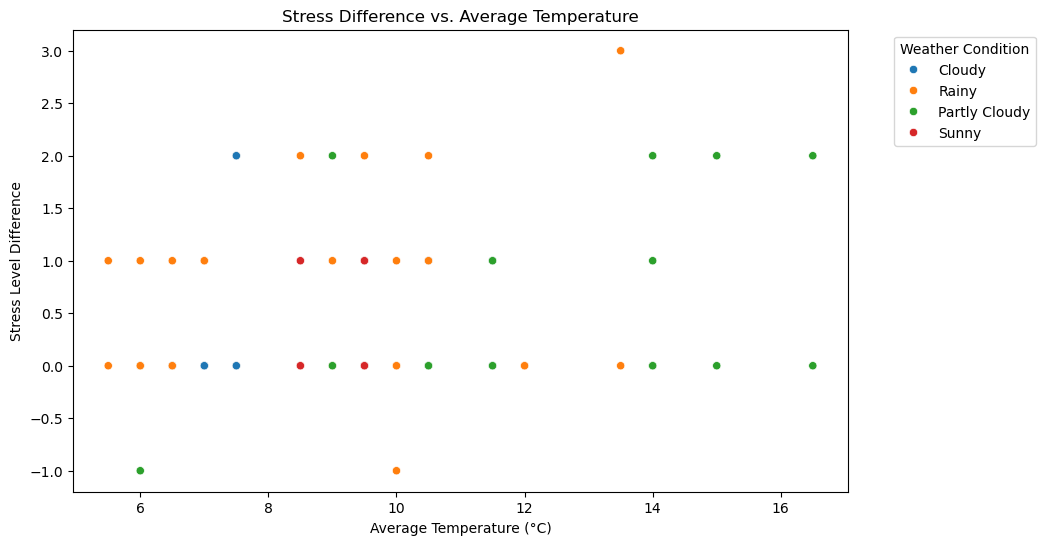

In [267]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AvgTemp', y='StressLevelDifference', hue='WeatherCondition', data=df, palette="tab10")
plt.title("Stress Difference vs. Average Temperature")
plt.xlabel("Average Temperature (\u00B0C)")
plt.ylabel("Stress Level Difference")
plt.legend(title="Weather Condition", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [268]:
### Correlation Heatmap

<Figure size 1400x1000 with 0 Axes>

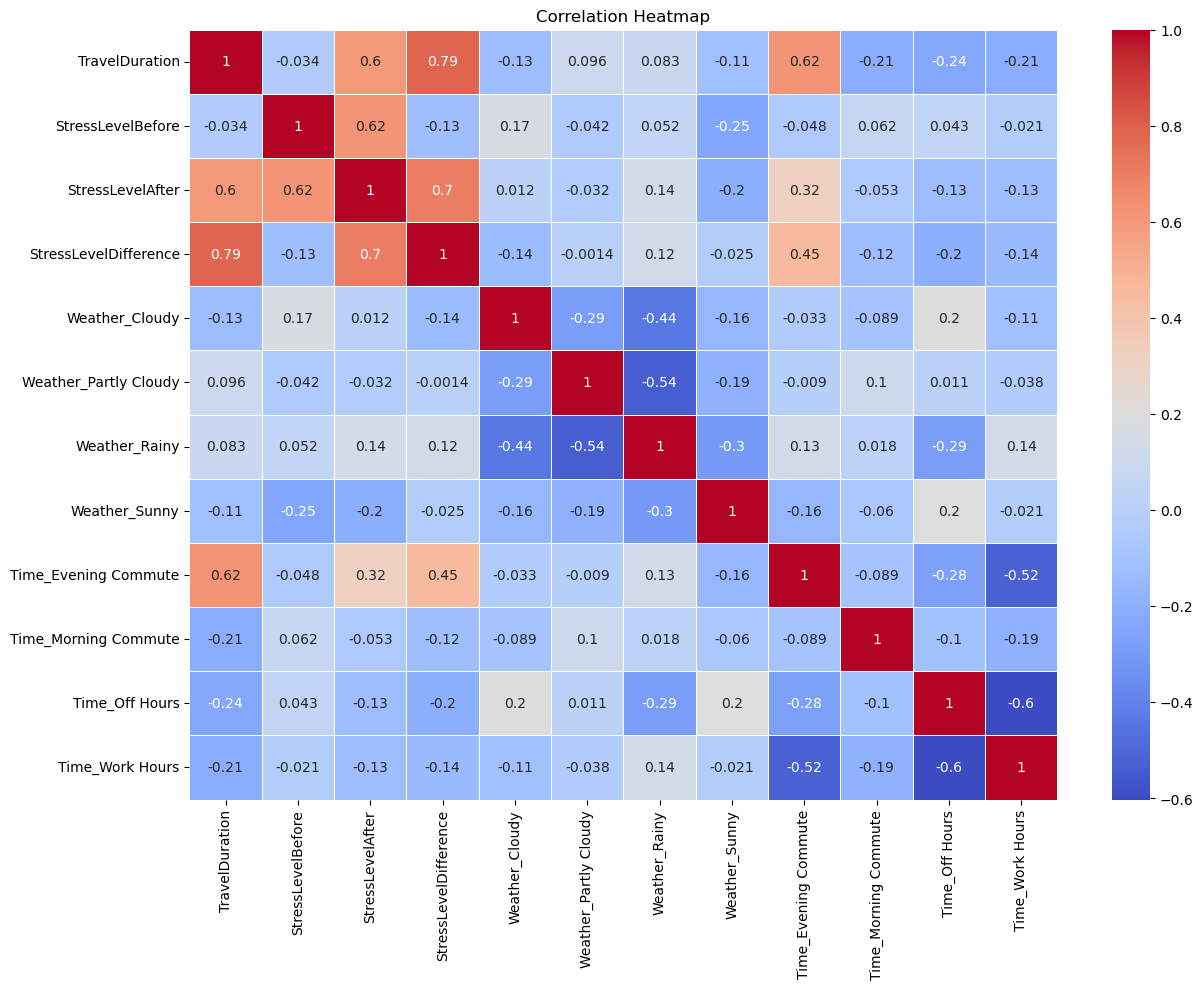

In [269]:
def categorize_time(hour):
    if 6 <= hour < 9:  # Morning commute
        return "Morning Commute"
    elif 16 <= hour < 19:  # Evening commute
        return "Evening Commute"
    elif 9 <= hour < 16:  # Work hours
        return "Work Hours"
    else:  # Off hours
        return "Off Hours"

df['TimeCategory'] = df['DepartureTime'].apply(lambda x: categorize_time(x.hour))

# One-Hot Encode TimeCategory for Correlation Analysis
time_encoded = pd.get_dummies(df['TimeCategory'], prefix='Time')
df = pd.concat([df, time_encoded], axis=1)



plt.figure(figsize=(14, 10))


plt.figure(figsize=(14, 10))
correlation = df[['TravelDuration', 'StressLevelBefore', 'StressLevelAfter', 
                  'StressLevelDifference'] + 
                 list(weather_encoded.columns) + list(time_encoded.columns)].corr()

sns.heatmap(correlation, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


<Figure size 1400x700 with 0 Axes>

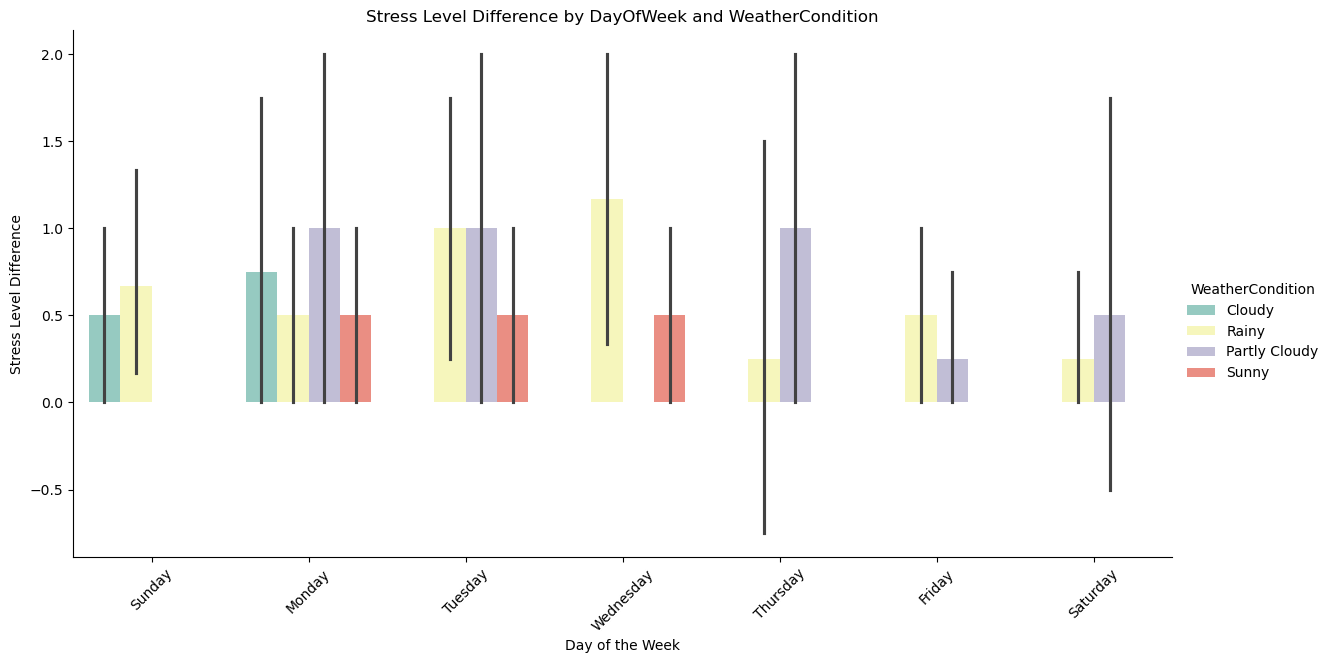

In [270]:
plt.figure(figsize=(14, 7))
sns.catplot(x='DayOfWeek', y='StressLevelDifference', hue='WeatherCondition', kind='bar', data=df, height=6, aspect=2, palette="Set3")
plt.title("Stress Level Difference by DayOfWeek and WeatherCondition")
plt.xlabel("Day of the Week")
plt.ylabel("Stress Level Difference")
plt.xticks(rotation=45)
plt.show()

In [271]:
### **Regression Analysis**

Linear Regression Results:
 - Mean Squared Error: 0.26
 - R² Score: 0.62


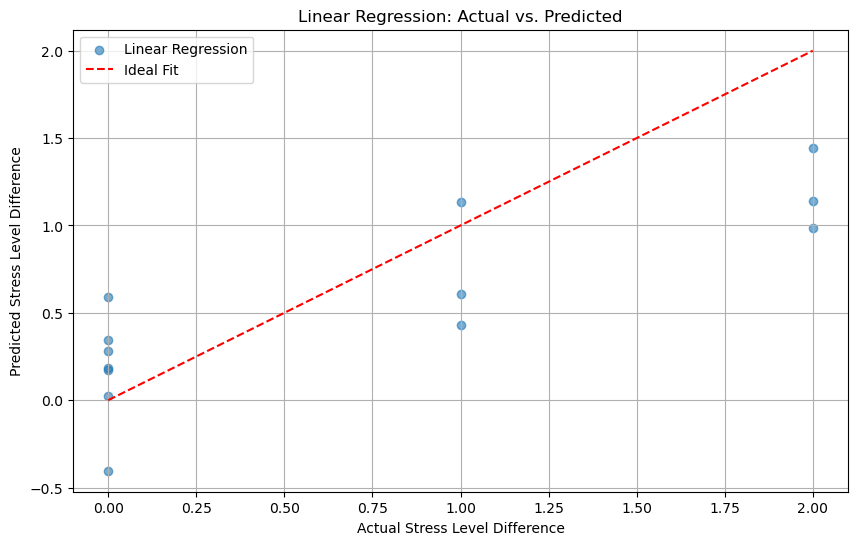

Decision Tree Results:
 - Mean Squared Error: 0.38
 - R² Score: 0.43


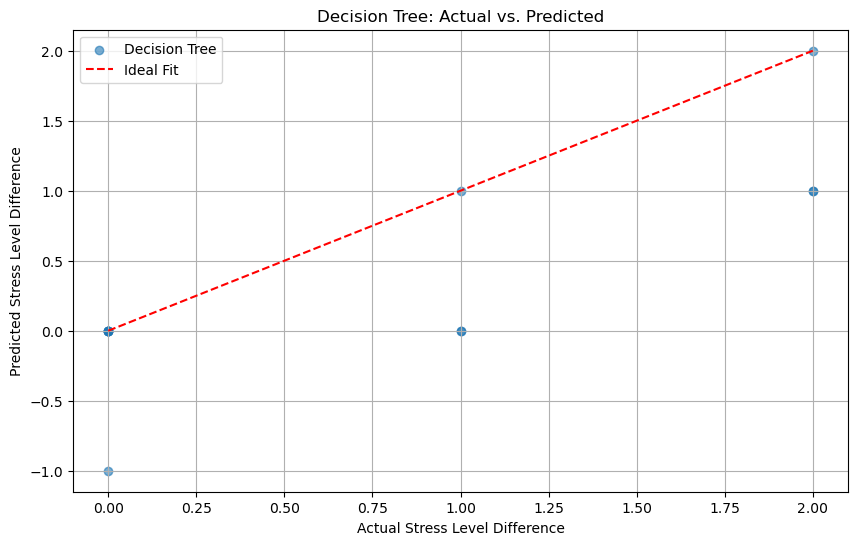

Random Forest Results:
 - Mean Squared Error: 0.30
 - R² Score: 0.56


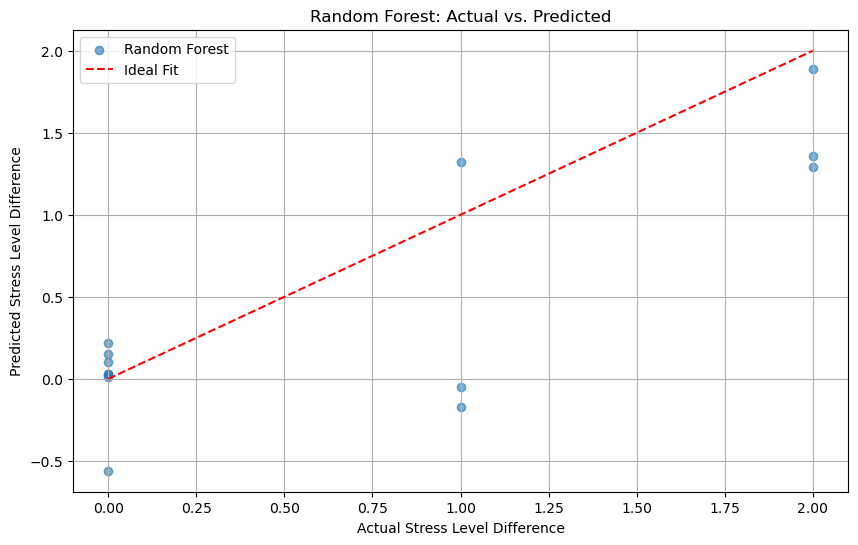

Best Performing Model: Linear Regression with R² = 0.62


In [272]:
X = df[['TravelDuration', 'HighTemp', 'LowTemp', 'StressLevelBefore'] + list(weather_encoded.columns)]
y = df['StressLevelDifference']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100)
}


results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R²": r2}
    print(f"{name} Results:\n - Mean Squared Error: {mse:.2f}\n - R² Score: {r2:.2f}")

    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.6, label=name)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Ideal Fit")
    plt.title(f"{name}: Actual vs. Predicted")
    plt.xlabel("Actual Stress Level Difference")
    plt.ylabel("Predicted Stress Level Difference")
    plt.legend()
    plt.grid(True)
    plt.show()



best_model = max(results, key=lambda x: results[x]['R²'])
print(f"Best Performing Model: {best_model} with R² = {results[best_model]['R²']:.2f}")

In [273]:
correlation_coefficient, p_value = pearsonr(df['TravelDuration'], df['StressLevelDifference'])

print(f"Pearson Correlation Coefficient: {correlation_coefficient:.2f}")
print(f"P-Value: {p_value:.2f}")


if p_value < 0.05:
    print("The p-value is less than 0.05. We reject the null hypothesis.")
else:
    print("The p-value is greater than or equal to 0.05. We fail to reject the null hypothesis.")

Pearson Correlation Coefficient: 0.79
P-Value: 0.00
The p-value is less than 0.05. We reject the null hypothesis.
